# Problem Statement

## Natural Language Processing with Disaster Tweets

This project imports the Natural Language Processing with Disaster Tweets dataset from Kaggle (https://www.kaggle.com/c/nlp-getting-started/overview). Using this dataset, the project will seek to establish a recurrent neural network (RNN) with a decent validation score for text classification as disaterous or nondisasterous.

This has great implications, as Twitter provides access to near real-time data. People from all over the world are quickly able to upload information about events that are happening in the moment.

## Exploratory Data Analysis (EDA)

### 1. Data Structure, Exploration, and Observation

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/nlp-getting-started.zip', 'r') as zip_ref:
    zip_ref.extractall('NLP Disaster Tweets')

The data comes with three csv files: test.csv, train.csv, and a sample_submission.csv.

Visualize train.csv:

In [3]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/NLP Disaster Tweets/train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


From the above, no keywords or location data can be seen. How many of the records for keyword and location can be used?

In [4]:
df_keywords = df[df['keyword'].notna()].copy()
print(f'There are {len(df_keywords)} records with keywords.')

df_locations = df[df['location'].notna()].copy()
print(f'There are {len(df_locations)} records with locations.')

print(f'There are {len(df)} total rows.')

There are 7552 records with keywords.
There are 5080 records with locations.
There are 7613 total rows.


Since there is so much missing data, the RNN will only be trained on the text portion of the dataset.

### 2. Data Distribution

A historgram will now be generated for the length of texts.

<Axes: >

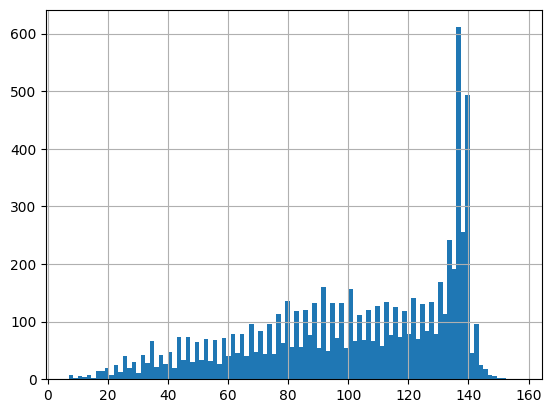

In [5]:
df['text_length'] = df['text'].apply(lambda x: len(x)).copy()
df['text_length'].hist(bins=100)

Interestingly, the distribution of text lengths is skewed, with the bulk of the train dataset containing over 100 words. This may have an affect on the accuracy of the model.

Now, the distribution of disasterous (target=1) and nondisasterous (target=0) will be visualized.

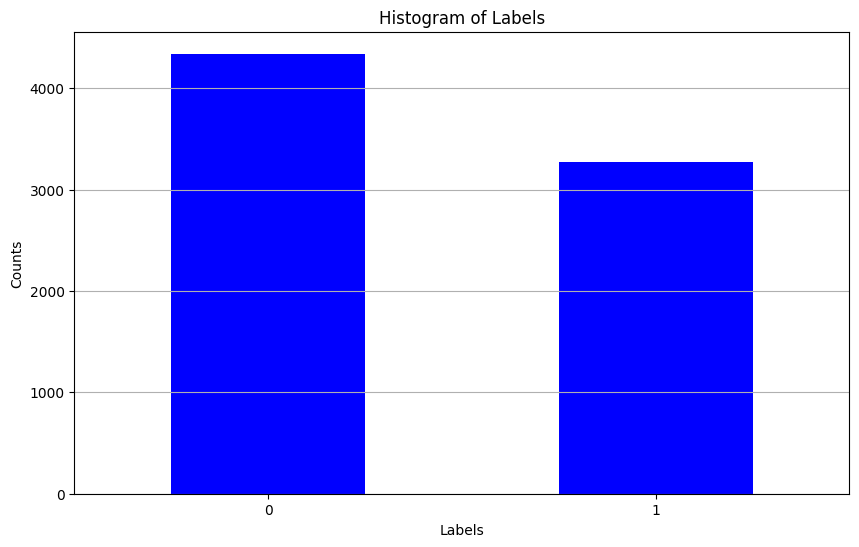

In [6]:
import matplotlib.pyplot as plt

# get label counts
label_counts = df['target'].value_counts()

# plot histogram
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='blue')
plt.title('Histogram of Labels')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

The distribution of disasterous and nondisasterous tweets suggest the model may have bias toward nondisasterous. This will need to be watched in the validation section.

#### Summary of Observations:



*   The training dataset favors nondisasterous tweets
*   There are more tweets with 100 words or more than otherwise
* Keyword and Location attributes are not populated enough to be included in the model.

### 3. Data Preprocessing

Some helpful standard practices in natural language processing:

* Remove punctuation
* Remove stopwords
* Remove non-alphabet characters
* Strip strings of extra whitepspace characters
* Correct spelling mistakes

In [7]:
df_train = df.drop(columns=['keyword', 'location', 'text_length', 'id']).copy()
print('Unprocessed Dataframe:')
df_train.head()

Unprocessed Dataframe:


,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
import wordcloud
import string
try:
  from autocorrect import Speller
except:
  !pip install autocorrect
  from autocorrect import Speller

# remove punctuation
df_train['text'] = df_train['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# remove stopwords and make lower case
df_train['text'] = df_train['text'].apply(lambda x: ' '.join([word.lower() for word in x.split() if word.lower() not in wordcloud.STOPWORDS]))

# remove non-alphabetic words
df_train['text'] = df_train['text'].apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))

# correct spelling mistakes
spell = Speller(lang='en')
df_train['text'] = df_train['text'].apply(lambda x: ' '.join([spell(word) for word in x.split()]))

# print
print('\nProcessed Dataframe:')
df_train.head()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622364 sha256=d5ad089bd098209b83128a3017d1a542d8a6cec30664df6209cac33459f1b698
  Stored in directory: /root/.cache/pip/wheels/5e/90/99/807a5ad861ce5d22c3c299a11df8cba9f31524f23ae6e645cb
Successfully built autocorrect

Processed Dataframe:


,text,target
0,deeds reason earthquake may alla forgive us,1
1,forest fire near la range task canada,1
2,residents asked shelter place notified officer...,1
3,people receive wildfires evacuation orders cal...,1
4,got sent photo ruby alaska smoke wildfires pou...,1


Now that the text has been cleaned, a tokenizer will be applied.

In [9]:
try:
  import keras
  from keras_hub.tokenizers import Tokenizer
except:
  !pip install keras
  from keras_hub.tokenizers import Tokenizer

# tokenize
tokenizer = Tokenizer.from_preset("bert_base_en")
tokenizer(df_train['text'])

# save the tokenizer
tokenizer.save_to_preset('/content/drive/MyDrive/NLP_Disaster_Tweets/tokenizer_preset')

100%|██████████| 510/510 [00:00<00:00, 1.07MB/s]


100%|██████████| 548/548 [00:00<00:00, 983kB/s]


100%|██████████| 208k/208k [00:00<00:00, 2.02MB/s]


In [10]:
# tokenize the input
df_train['text'] = tokenizer(df_train['text'])
df_train.head()

,text,target
0,"[19301, 2255, 8386, 1336, 1155, 1161, 10737, 1...",1
1,"[3304, 1783, 1485, 2495, 2079, 4579, 1169, 7971]",1
2,"[3159, 1455, 7890, 1282, 21568, 3099, 15346, 7...",1
3,"[1234, 3531, 4098, 20259, 15346, 3791, 11019, ...",1
4,"[1400, 1850, 6307, 16259, 1183, 2393, 25611, 1...",1


The last step will be to regularize each input.

In [11]:
try:
  from tensorflow.keras.preprocessing.sequence import pad_sequences
except:
  !pip install tensorflow
  from tensorflow.keras.preprocessing.sequence import pad_sequences

# regularize each input array of tokens
df_train['text'] = df_train['text'].apply(lambda x: pad_sequences([x], maxlen=600)[0])
df_train.head()

,text,target
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1


## Model Architecture

The two prevailing model architectures for RNN's are Long-Term Short Memory (LTSM) and Gated Recurrent Unit (GRU).

### LTSM

This architecture uses an input, output, and forget gate to decide which data in an array should remain relevant in the training.

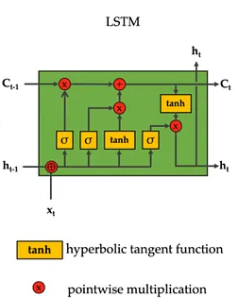

*Source: https://medium.com/@hassaanidrees7/rnn-vs-lstm-vs-gru-a-comprehensive-guide-to-sequential-data-modeling-03aab16647bb*

LTSM is generally accepted as the most accurate RNN strategy, but it may take longer to train than other strategies.

### GRU

Another strategy is the Gated Recurrent Unit, which uses a simplified gate from the LTSM approach. The GRU gate can only update or reset.

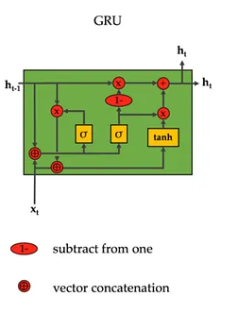

*Source: https://medium.com/@hassaanidrees7/rnn-vs-lstm-vs-gru-a-comprehensive-guide-to-sequential-data-modeling-03aab16647bb*

This option is simplier and much faster to train than LTSM, but it may not be as accurate.

## Chosen Architecture

This project will take the LTSM approach to take advantage of the greater accuracy in the model.

The network architecture will begin as such:

1. Input layer
2. Embedding layer
3. LTSM layer #1
4. LTSM layer #2
5. Output Layer (Sigmoid)

Using Google Colab's gpu trining:

In [12]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Fri Feb 28 19:35:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P0             52W /  400W |     429MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [13]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Input

# Function to set up the neural network
def create_lstm_model(vocab_size, embedding_dim, max_length):
    model = Sequential()
    # Input Layer
    model.add(Input(shape=(max_length,)))
    # Embedding Layer
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
    # LTSM Layer 1
    model.add(LSTM(100, return_sequences=True, input_shape=(max_length, embedding_dim)))
    # LTSM Layer 2
    model.add(LSTM(50))
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    # Compile for binary output using adam optimizer
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Inputs
token_vocab = pd.read_table('/content/drive/MyDrive/NLP_Disaster_Tweets/tokenizer_preset/assets/tokenizer/vocabulary.txt')
vocab_size = len(token_vocab) + 1
embedding_dim = 128
max_length = 500

# Build the model
model = create_lstm_model(vocab_size, embedding_dim, max_length)
model.build(input_shape=(None, max_length))
print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 500, 128)            │         125,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 500, 100)            │          91,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 246,907 (964.48 KB)

 Trainable params: 246,907 (964.48 KB)

 Non-trainable params: 0 (0.00 B)

None


Now that the model architecture is set, the training can begin.

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.5666 - loss: 0.6762 - val_accuracy: 0.5391 - val_loss: 0.6892
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.5878 - loss: 0.6657 - val_accuracy: 0.5489 - val_loss: 0.6774
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.5792 - loss: 0.6681 - val_accuracy: 0.5391 - val_loss: 0.6830
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.5833 - loss: 0.6690 - val_accuracy: 0.5469 - val_loss: 0.6816
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.5995 - loss: 0.6653 - val_accuracy: 0.5732 - val_loss: 0.6748
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.6005 - loss: 0.6595 - val_accuracy: 0.5535 - val_loss: 0.6784
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.5965 - loss: 0.6671 - val_accuracy: 0.5620 - val_loss: 0.6759
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.6050 - loss: 0.6640 - val_acc

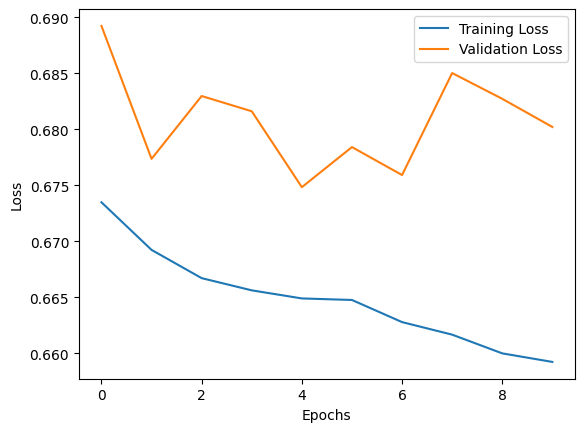

In [14]:
import numpy as np

# Set training data
x_train = np.array(df_train['text'].to_list())
y_train = np.array(df_train['target'].to_list())

# Train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Plot loss history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Results and Analysis

It does not seem that 10 epochs was enough to acheive convergence. Especially on the validation set.

Possible solutions:
* Increase number of epochs
* Add a leaning rate
* Schedule learning rate reduction

### Hyperparameter Tuning

The below code will implement 30 epochs with an Adam optimizer scheduled to start at a learning rate of .001 and decrease over time.

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.5773 - loss: 0.6742 - val_accuracy: 0.5364 - val_loss: 0.6814 - learning_rate: 0.0010
Epoch 2/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.5854 - loss: 0.6686 - val_accuracy: 0.5456 - val_loss: 0.6807 - learning_rate: 0.0010
Epoch 3/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.5875 - loss: 0.6681 - val_accuracy: 0.5634 - val_loss: 0.6806 - learning_rate: 0.0010
Epoch 4/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.5930 - loss: 0.6691 - val_accuracy: 0.5568 - val_loss: 0.6811 - learning_rate: 0.0010
Epoch 5/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.6055 - loss: 0.6621 - val_accuracy: 0.5476 - val_loss: 0.6788 - learning_rate: 0.0010
Epoch 6/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.5982 - loss: 0.6613 - val_accuracy: 0.5581 - val_loss: 0.6790 - learning_rate: 1.0000e-04
Epoch 7/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.6020 - loss: 0.6613 -

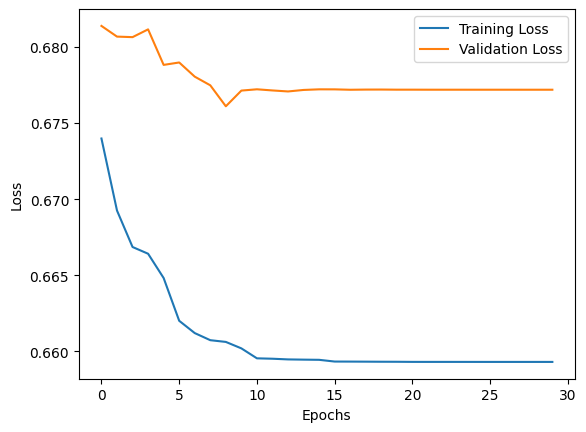

In [16]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Input

# Function to set up the neural network
def create_lstm_model(vocab_size, embedding_dim, max_length, learning_rate):
    model = Sequential()
    # Input Layer
    model.add(Input(shape=(max_length,)))
    # Embedding Layer
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
    # LTSM Layer 1
    model.add(LSTM(100, return_sequences=True, input_shape=(max_length, embedding_dim)))
    # LTSM Layer 2
    model.add(LSTM(50))
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    # set optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile for binary output using adam optimizer
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Function to schedule learning rate reduction
def learning_schedule(epoch, lr):
    if epoch % 5 == 0 and epoch != 0:
        lr = lr * 0.1
    return lr

# Inputs
token_vocab = pd.read_table('/content/drive/MyDrive/NLP_Disaster_Tweets/tokenizer_preset/assets/tokenizer/vocabulary.txt')
vocab_size = len(token_vocab) + 1
embedding_dim = 128
max_length = 500
learning_rate = 0.001
learning_scheduler = tf.keras.callbacks.LearningRateScheduler(learning_schedule)

# Build model
model = create_lstm_model(vocab_size, embedding_dim, max_length, learning_rate)
model.build(input_shape=(None, max_length))

# Train the model
history = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=[learning_scheduler])

# Plot loss history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Now, convergence can be seen in both training and validation. The loss is still high, so further exploration could be done in the preprocessing of the texts. This further exploration is outside of the scope of this project, however.

## Submission

Below is the code to predict the test dataset.

In [42]:
# Read the test dataset
df_test = pd.read_csv('/content/drive/MyDrive/NLP Disaster Tweets/test.csv')

# Preprocess the data
df_test.drop(columns=['keyword', 'location'], inplace=True)

# Remove punctuation
df_test['text'] = df_test['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Remove stopwords and make lower case
df_test['text'] = df_test['text'].apply(lambda x: ' '.join([word.lower() for word in x.split() if word.lower() not in wordcloud.STOPWORDS]))

# Remove non-alphabetic words
df_test['text'] = df_test['text'].apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))

# Correct spelling mistakes
spell = Speller(lang='en')
df_test['text'] = df_test['text'].apply(lambda x: ' '.join([spell(word) for word in x.split()]))

# tokenize
df_test['text'] = tokenizer(df_test['text'])

# Pad sequences
df_test['text'] = df_test['text'].apply(lambda x: pad_sequences([x], maxlen=600)[0])

df_test.head()

,id,text
0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,9,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,11,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [43]:
# Predict results
results = model.predict(np.array(df_test['text'].tolist()))

# Prepare submission df
df_submission = pd.DataFrame()
df_submission['id'] = df_test['id']
df_submission['target'] = np.round(results).astype(int)
df_submission.head()

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [44]:
# To csv
df_submission.to_csv('submission.csv', index=False)

## Conclusion

While the LTSM did not perform as well as hoped for, some takeaways can be gained from the experiment:

1. More research on better preprocessing or embedding.
2. Adding more dense layers instead of just two LTSM layers.
3. Training on a GPU is incredibly faster than training on a CPU.

The first iteration of this project would take about 30 mins to run on a CPU, but taking advantage of Google Colab GPU tokens, 10 epochs could be done in about a minute. This is advantageous for anyone training neural networks.